In [ ]:
pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import files
import io
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, RocCurveDisplay, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import scipy.stats as stats
from sklearn import tree
from imblearn.under_sampling import RandomUnderSampler

#warnings.filterwarnings('ignore')

#uploaded = files.upload()

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read the dataset into a Pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/Data/TMU DM+Complic+Med Category 808K Jan 2025 R1.csv')

# Display the first few rows of the dataset to ensure it's loaded correctly
df.head()

df.shape

<ipython-input-4-da6843f891d3>:2: DtypeWarning: Columns (28,29,31,33,35,37,39,41,43,47,49,51,55,57,59,61,63,65,67,69,71,77,79,81,83,85,87,91,93,95,97,101,103,105,107,109,136,137,139,140,145,148,153,156,161,163,164,168,169,171,172) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Data/TMU DM+Complic+Med Category 808K Jan 2025 R1.csv')


(808921, 175)

In [ ]:
patients_with_diabetes = df.loc[df["Diabetes"] == 1, "Patient_ID"].dropna().unique()
df_diabetes = df[df["Patient_ID"].isin(list(patients_with_diabetes))]

In [ ]:
patients_without_diabetes = df.loc[df["Diabetes"] == 0, "Patient_ID"].dropna().unique()
df_no_diabetes = df[df["Patient_ID"].isin(list(patients_without_diabetes))]

In [ ]:
df['Diabetes'].value_counts()

,count
Diabetes,
0,574457
1,234464


In [ ]:
num_duplicates = df['Patient_ID'].duplicated().sum()
print(f"Number of duplicate Patient_IDs: {num_duplicates}")


Number of duplicate Patient_IDs: 637302


In [ ]:
df_diabetes.shape

(234464, 175)

# Creating dataframes for diabetics, non-diabetics and total patients

In [ ]:
df_diabetes = df_diabetes.copy()  # This removes the warning
df_diabetes["Has_Any_Psych_Condition"] = (
    (df_diabetes["[Anxiety)"] == 1) |
    (df_diabetes["Depression"] == 1)
).astype(int)

df_DB_last_record = df_diabetes.sort_values(by="sBP_Date", ascending=False).drop_duplicates(subset="Patient_ID", keep="first")

In [ ]:
df_no_diabetes = df_no_diabetes.copy()  # This removes the warning
df_no_diabetes["Has_Any_Psych_Condition"] = (
    (df_no_diabetes["[Anxiety)"] == 1) |
    (df_no_diabetes["Depression"] == 1)
).astype(int)

df_ND_last_record = df_no_diabetes.sort_values(by="sBP_Date", ascending=False).drop_duplicates(subset="Patient_ID", keep="first")

In [ ]:
df_all = df.copy()  # This removes the warning
df_all["Has_Any_Psych_Condition"] = (
    (df_all["[Anxiety)"] == 1) |
    (df_all["Depression"] == 1)
).astype(int)

df_all_last_record = df_all.sort_values(by="sBP_Date", ascending=False).drop_duplicates(subset="Patient_ID", keep="first")

In [ ]:
df_DB_last_record.shape

(25920, 176)

In [ ]:
df_DB_last_record['Has_Any_Psych_Condition'].value_counts()

,count
Has_Any_Psych_Condition,
0,20333
1,5587


In [ ]:
df_ND_last_record.shape

(145699, 176)

In [ ]:
df_ND_last_record['Has_Any_Psych_Condition'].value_counts()

,count
Has_Any_Psych_Condition,
0,115380
1,30319


In [ ]:
df_all_last_record.shape

(171619, 176)

In [ ]:
df_all_last_record['Has_Any_Psych_Condition'].value_counts()

,count
Has_Any_Psych_Condition,
0,135713
1,35906


# SELECTING COLUMNS

In [ ]:
selectedD = df_DB_last_record[[
"Age_at_Exam",
"Sex",
"sBP",
#"BMI",
"LDL",
#"HDL",
#"A1c",
"TG",
"FBS",
"b_R1_skin",
"b_R1_foot",
"b_R1_heart",
"b_R1_eye",
"b_R1_cancer",
"b_R1_kidney",
"b_R1_brain",
"b_R1_death",
"b_R1_gastric",
"b_R1_pancreas",
"b_R1_sleep",
                            "Has_Any_Psych_Condition"
]]


# Assuming your DataFrame is named df
selectedD = pd.get_dummies(selectedD, columns=['Sex'], drop_first=True)


In [ ]:
selectedND = df_ND_last_record[[
"Age_at_Exam",
"Sex",
"sBP",
#"BMI",
"LDL",
#"HDL",
#"A1c",
"TG",
"FBS",
"b_R1_skin",
"b_R1_foot",
"b_R1_heart",
"b_R1_eye",
"b_R1_cancer",
"b_R1_kidney",
"b_R1_brain",
"b_R1_death",
"b_R1_gastric",
"b_R1_pancreas",
"b_R1_sleep",
                            "Has_Any_Psych_Condition"
]]


# Assuming your DataFrame is named df
selectedND = pd.get_dummies(selectedND, columns=['Sex'], drop_first=True)

In [ ]:
selectedALL = df_all_last_record[[
"Age_at_Exam",
"Sex",
"sBP",
#"BMI",
"LDL",
#"HDL",
#"A1c",
"TG",
"FBS",
"b_R1_skin",
"b_R1_foot",
"b_R1_heart",
"b_R1_eye",
"b_R1_cancer",
"b_R1_kidney",
"b_R1_brain",
"b_R1_death",
"b_R1_gastric",
"b_R1_pancreas",
"b_R1_sleep",
                            "Has_Any_Psych_Condition"
]]


# Assuming your DataFrame is named df
selectedALL = pd.get_dummies(selectedALL, columns=['Sex'], drop_first=True)

# MISSING VALUES

Diabetes

In [ ]:
# Calculate missing values and total values per column
missing_counts = selectedD.isna().sum()  # Count of missing values per column
total_counts = selectedD.shape[0]  # Total number of rows (same for all columns)
missing_percentage = (missing_counts / total_counts) * 100  # Convert to percentage

# Combine into a summary DataFrame
missing_summary = pd.DataFrame({
    #"Missing Values": missing_counts,
    #"Total Values": total_counts,
    "Missing Percentage": missing_percentage
})

# Display summary
print(missing_summary)

                         Missing Percentage
Age_at_Exam                        0.000000
sBP                                0.123457
LDL                                1.107253
TG                                 1.076389
FBS                                0.000000
b_R1_skin                          0.000000
b_R1_foot                          0.000000
b_R1_heart                         0.000000
b_R1_eye                           0.000000
b_R1_cancer                        0.000000
b_R1_kidney                        0.000000
b_R1_brain                         0.000000
b_R1_death                         0.000000
b_R1_gastric                       0.000000
b_R1_pancreas                      0.000000
b_R1_sleep                         0.000000
Has_Any_Psych_Condition            0.000000
Sex_Male                           0.000000


In [ ]:
# Fill missing values
selectedD = selectedD.assign(
    sBP=selectedD["sBP"].fillna(selectedD["sBP"].mean()),
    LDL=selectedD["LDL"].fillna(selectedD["LDL"].mean()),
    TG=selectedD["TG"].fillna(selectedD["TG"].median())
)

All

In [ ]:
# Calculate missing values and total values per column
missing_counts = selectedALL.isna().sum()  # Count of missing values per column
total_counts = selectedALL.shape[0]  # Total number of rows (same for all columns)
missing_percentage = (missing_counts / total_counts) * 100  # Convert to percentage

# Combine into a summary DataFrame
missing_summary = pd.DataFrame({
    #"Missing Values": missing_counts,
    #"Total Values": total_counts,
    "Missing Percentage": missing_percentage
})

# Display summary
print(missing_summary)

                         Missing Percentage
Age_at_Exam                        0.000000
sBP                                0.072836
LDL                                0.593757
TG                                 1.571504
FBS                                0.000000
b_R1_skin                          0.000000
b_R1_foot                          0.000000
b_R1_heart                         0.000000
b_R1_eye                           0.000000
b_R1_cancer                        0.000000
b_R1_kidney                        0.000000
b_R1_brain                         0.000000
b_R1_death                         0.000000
b_R1_gastric                       0.000000
b_R1_pancreas                      0.000000
b_R1_sleep                         0.000000
Has_Any_Psych_Condition            0.000000
Sex_Male                           0.000000


In [ ]:
# Fill missing values
selectedALL = selectedALL.assign(
    sBP=selectedALL["sBP"].fillna(selectedALL["sBP"].mean()),
    LDL=selectedALL["LDL"].fillna(selectedALL["LDL"].mean()),
    TG=selectedALL["TG"].fillna(selectedALL["TG"].median())
)

No diabetes

In [ ]:
# Calculate missing values and total values per column
missing_counts = selectedND.isna().sum()  # Count of missing values per column
total_counts = selectedND.shape[0]  # Total number of rows (same for all columns)
missing_percentage = (missing_counts / total_counts) * 100  # Convert to percentage

# Combine into a summary DataFrame
missing_summary = pd.DataFrame({
    #"Missing Values": missing_counts,
    #"Total Values": total_counts,
    "Missing Percentage": missing_percentage
})

# Display summary
print(missing_summary)

                         Missing Percentage
Age_at_Exam                        0.000000
sBP                                0.066576
LDL                                0.502406
TG                                 1.659586
FBS                                0.000000
b_R1_skin                          0.000000
b_R1_foot                          0.000000
b_R1_heart                         0.000000
b_R1_eye                           0.000000
b_R1_cancer                        0.000000
b_R1_kidney                        0.000000
b_R1_brain                         0.000000
b_R1_death                         0.000000
b_R1_gastric                       0.000000
b_R1_pancreas                      0.000000
b_R1_sleep                         0.000000
Has_Any_Psych_Condition            0.000000
Sex_Male                           0.000000


In [ ]:
# Fill missing values
selectedND = selectedND.assign(
    sBP=selectedND["sBP"].fillna(selectedND["sBP"].mean()),
    LDL=selectedND["LDL"].fillna(selectedND["LDL"].mean()),
    TG=selectedND["TG"].fillna(selectedND["TG"].median())
)

# DISTRIBUTION OF DATA

In [ ]:
# Function to compute statistics
def generate_summary(df):
    summary = df.describe().T  # Transpose for better readability
    summary = summary[['mean', '50%', 'std', 'max', 'min']]  # Select required metrics
    summary.rename(columns={'50%': 'median'}, inplace=True)  # Rename median column
    return summary

# Generate summaries
summary_ND = generate_summary(selectedND)
summary_D = generate_summary(selectedD)
summary_ALL = generate_summary(selectedALL)

# Display summaries
print("Summary for selectedND:\n", summary_ND)
print("\nSummary for selectedD:\n", summary_D)
print("\nSummary for selectedALL:\n", summary_ALL)

Summary for selectedND:
                                mean  median        std     max   min
Age_at_Exam               54.746910   54.00  14.851555   90.00  18.0
sBP                      124.554154  124.00  15.692864  241.00  40.0
LDL                        2.952294    2.90   0.879069   10.00   0.1
TG                         1.317567    1.13   0.790284   47.99   0.1
FBS                        5.141448    5.10   0.558915   14.30   2.1
b_R1_skin                  0.032265    0.00   0.176704    1.00   0.0
b_R1_foot                  0.006445    0.00   0.080021    1.00   0.0
b_R1_heart                 0.040632    0.00   0.197436    1.00   0.0
b_R1_eye                   0.014098    0.00   0.117894    1.00   0.0
b_R1_cancer                0.035306    0.00   0.184552    1.00   0.0
b_R1_kidney                0.011888    0.00   0.108380    1.00   0.0
b_R1_brain                 0.008655    0.00   0.092628    1.00   0.0
b_R1_death                 0.000103    0.00   0.010146    1.00   0.0
b_R1_gast

In [ ]:
# Function to calculate class distribution
def class_distribution(df, df_name):
    return df["Has_Any_Psych_Condition"].value_counts().rename_axis("Class").reset_index(name=df_name)

# Get class distribution for each dataframe
dist_all = class_distribution(selectedALL, "ALL")
dist_nd = class_distribution(selectedND, "ND")
dist_d = class_distribution(selectedD, "D")

# Merge distributions into a single table
class_dist_table = dist_all.merge(dist_nd, on="Class", how="outer").merge(dist_d, on="Class", how="outer")

# Fill NaN values with 0 (if any)
class_dist_table = class_dist_table.fillna(0)

# Display the table
print(class_dist_table)


   Class     ALL      ND      D
0      0  135713  115380  20333
1      1   35906   30319   5587


ALL

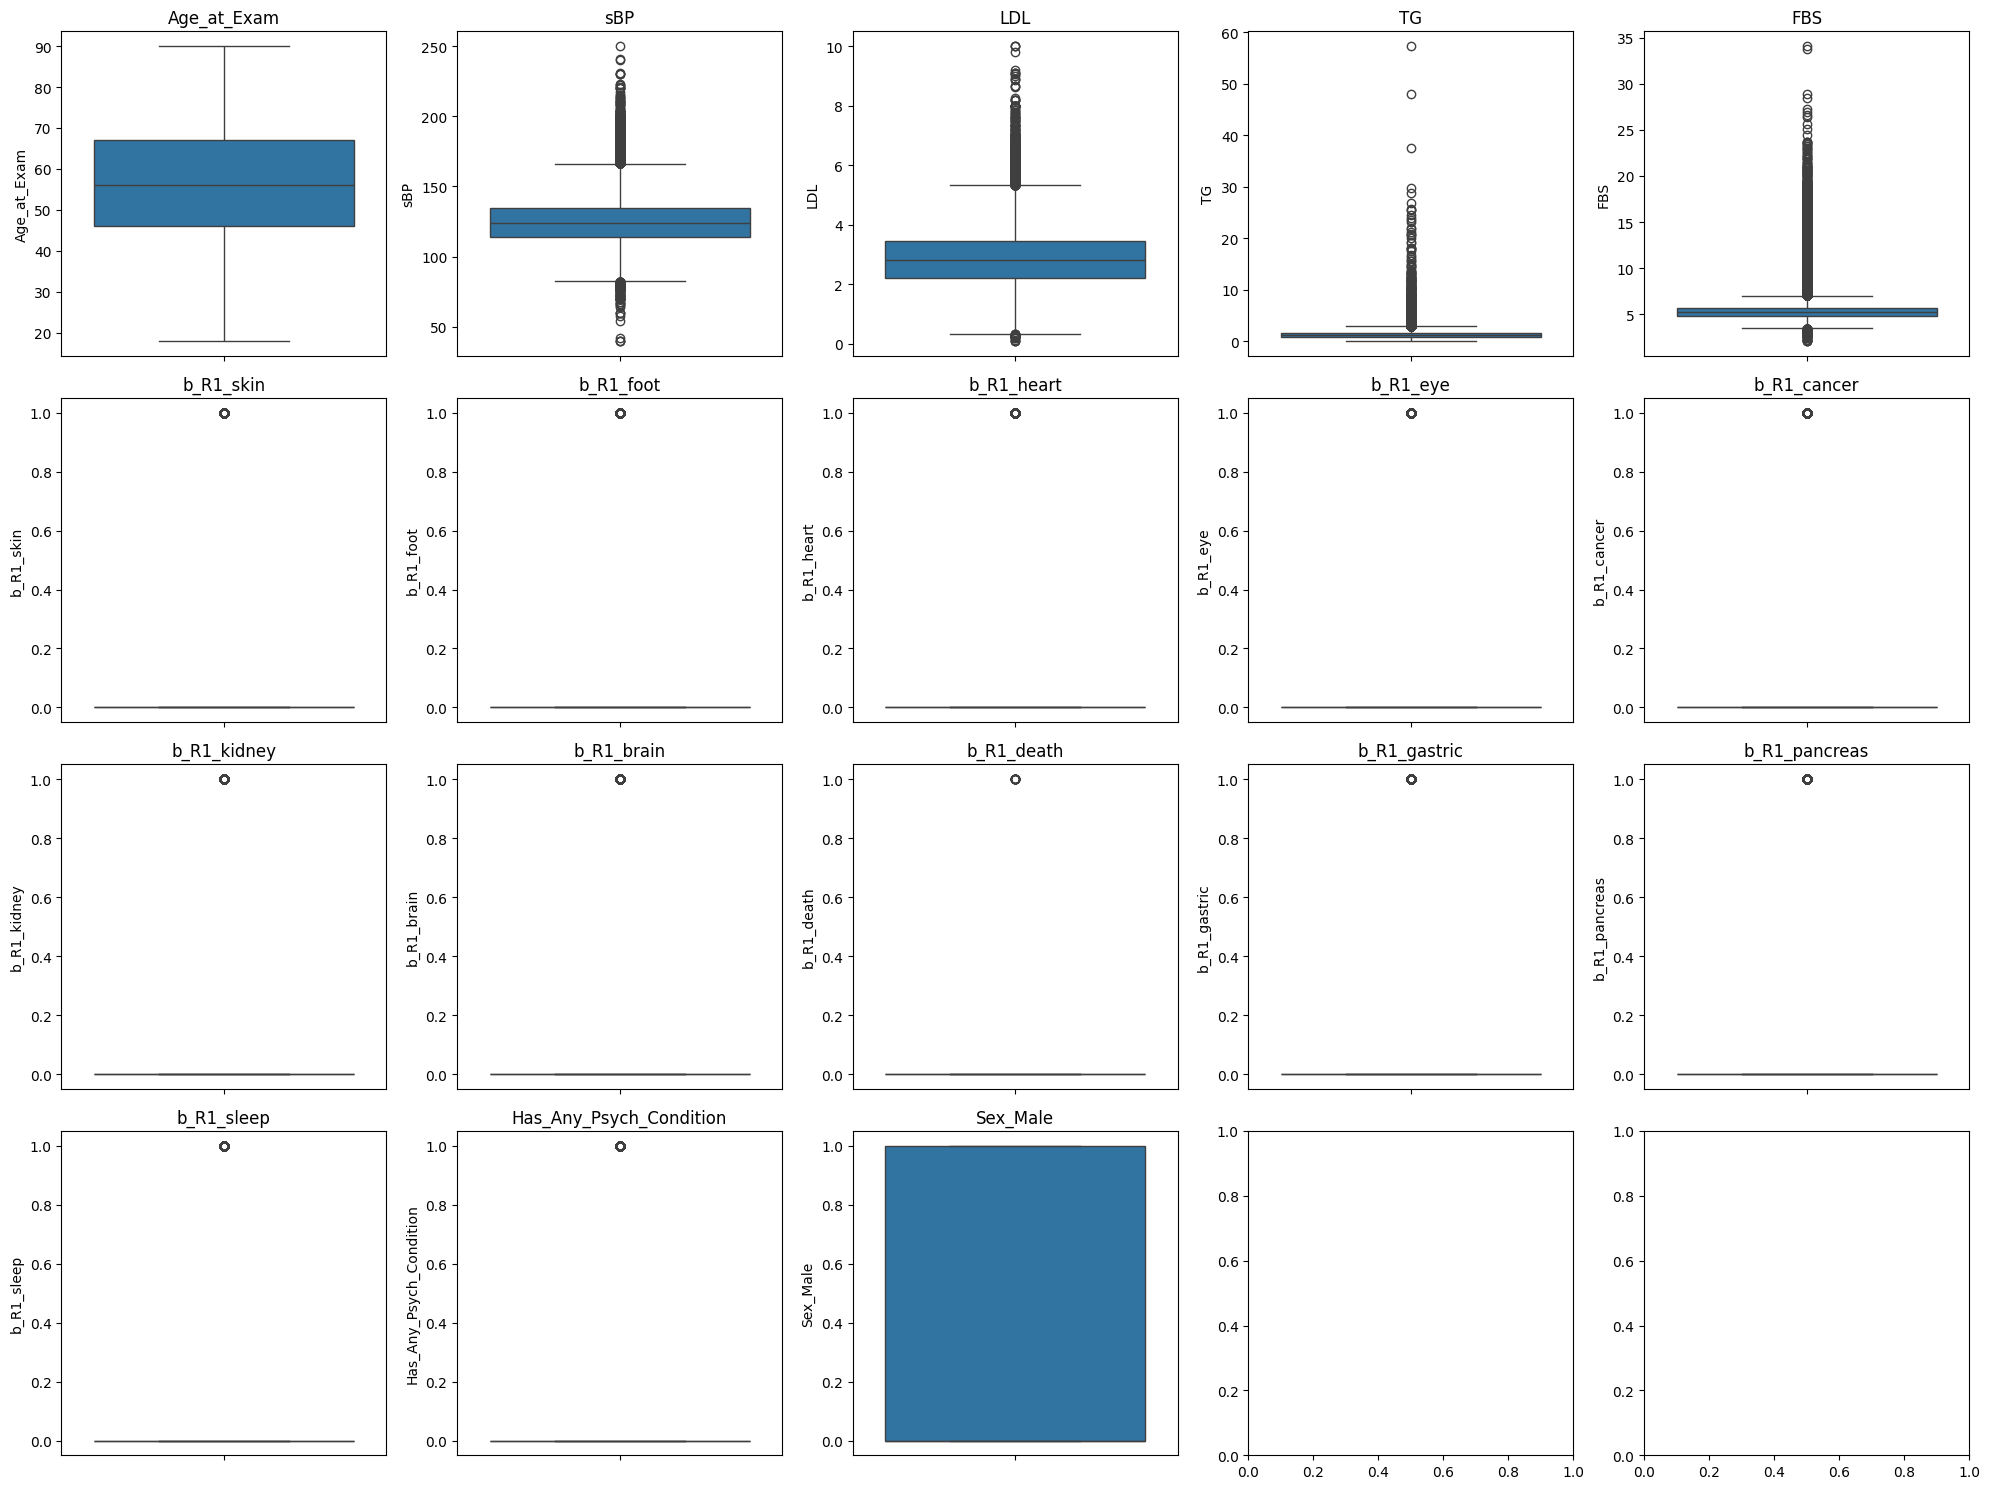

In [ ]:
# Set figure size
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 15))  # Adjust grid size based on number of columns
axes = axes.flatten()

# Plot each column separately
for i, col in enumerate(selectedALL.columns):
    sns.boxplot(y=selectedALL[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

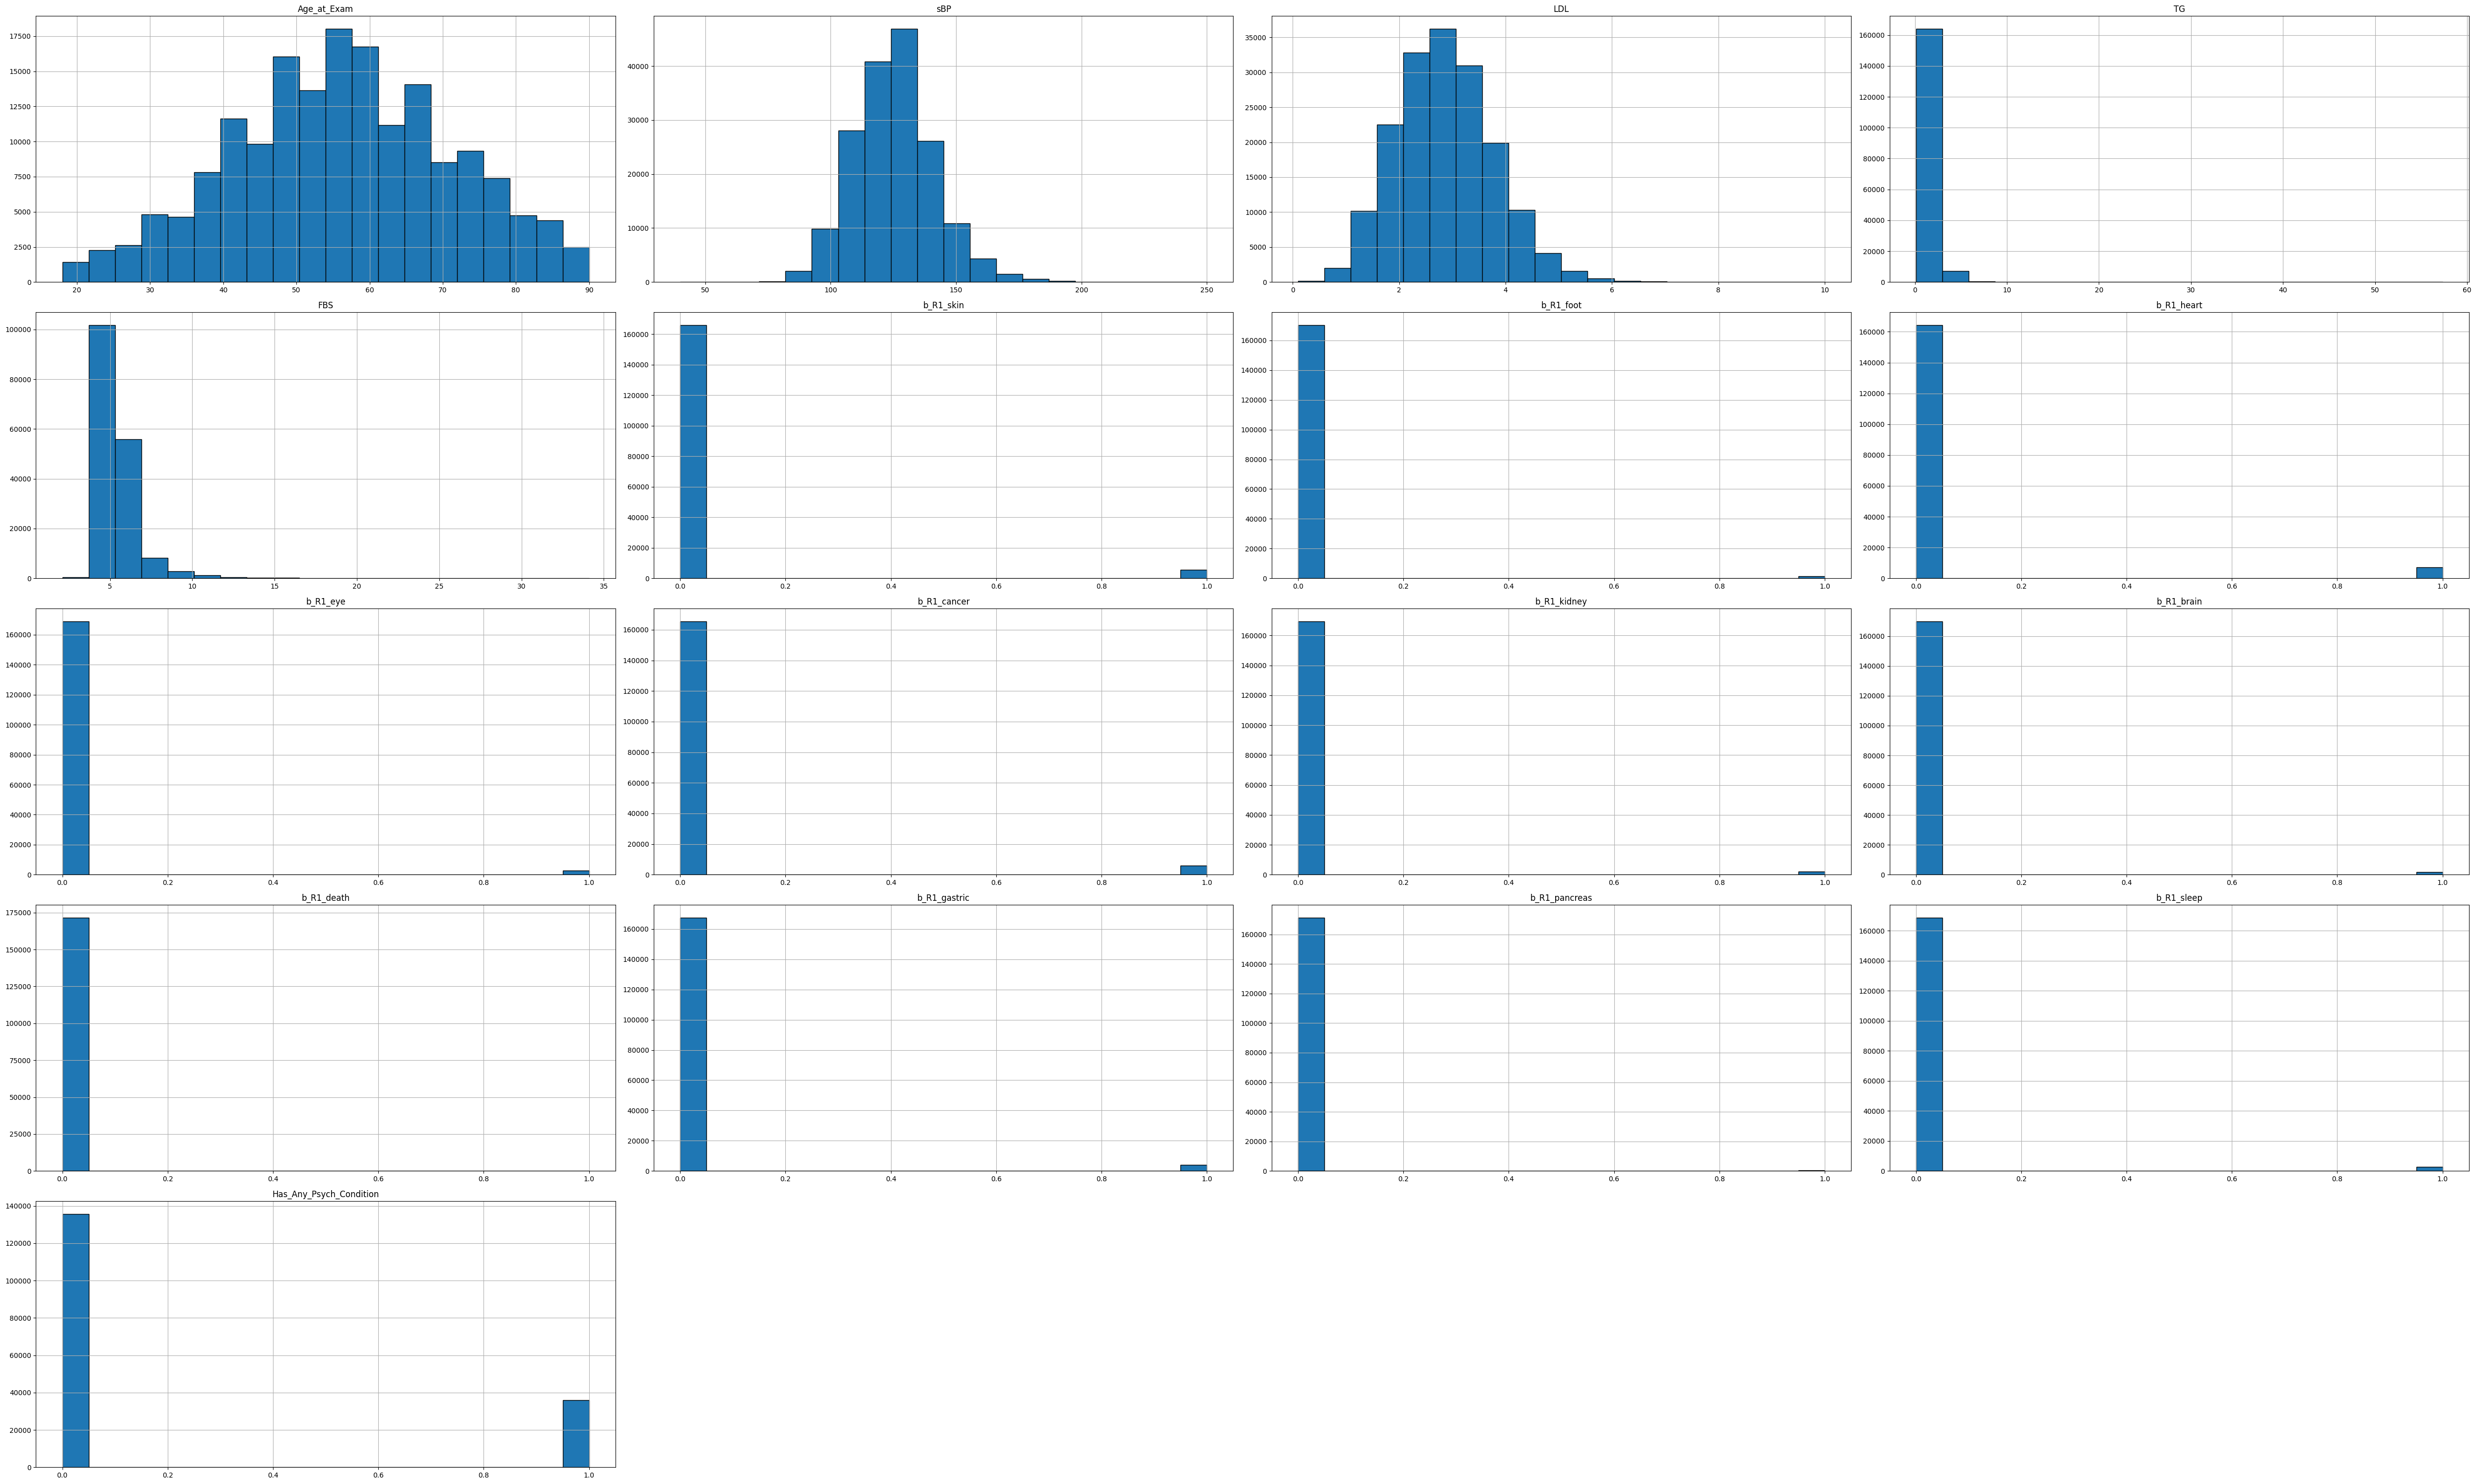

In [ ]:
# Set the number of bins for histograms
bins = 20

# Plot histograms for all numeric columns
selectedALL.hist(figsize=(50, 30), bins=bins, edgecolor="black")

# Show the plots
plt.tight_layout()
plt.show()

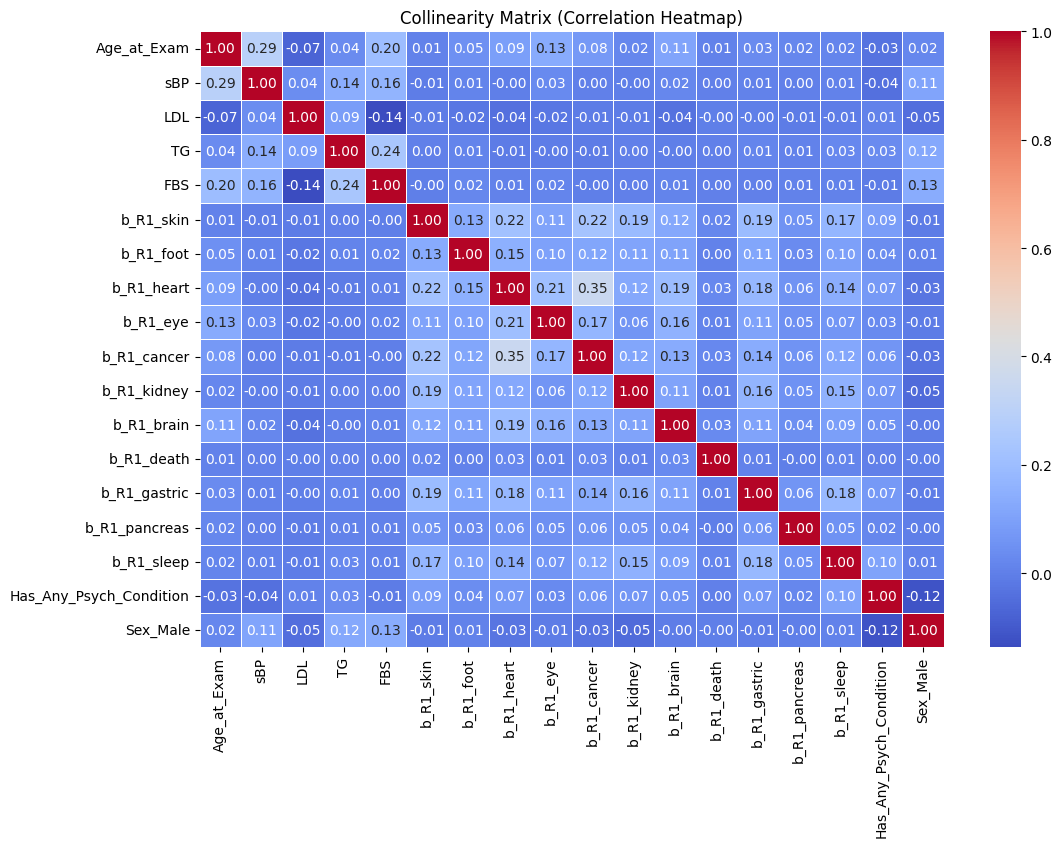

In [ ]:
# Compute the correlation matrix
corr_matrix = selectedALL.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Title
plt.title("Collinearity Matrix (Correlation Heatmap)")

# Show the plot
plt.show()

Diabetics

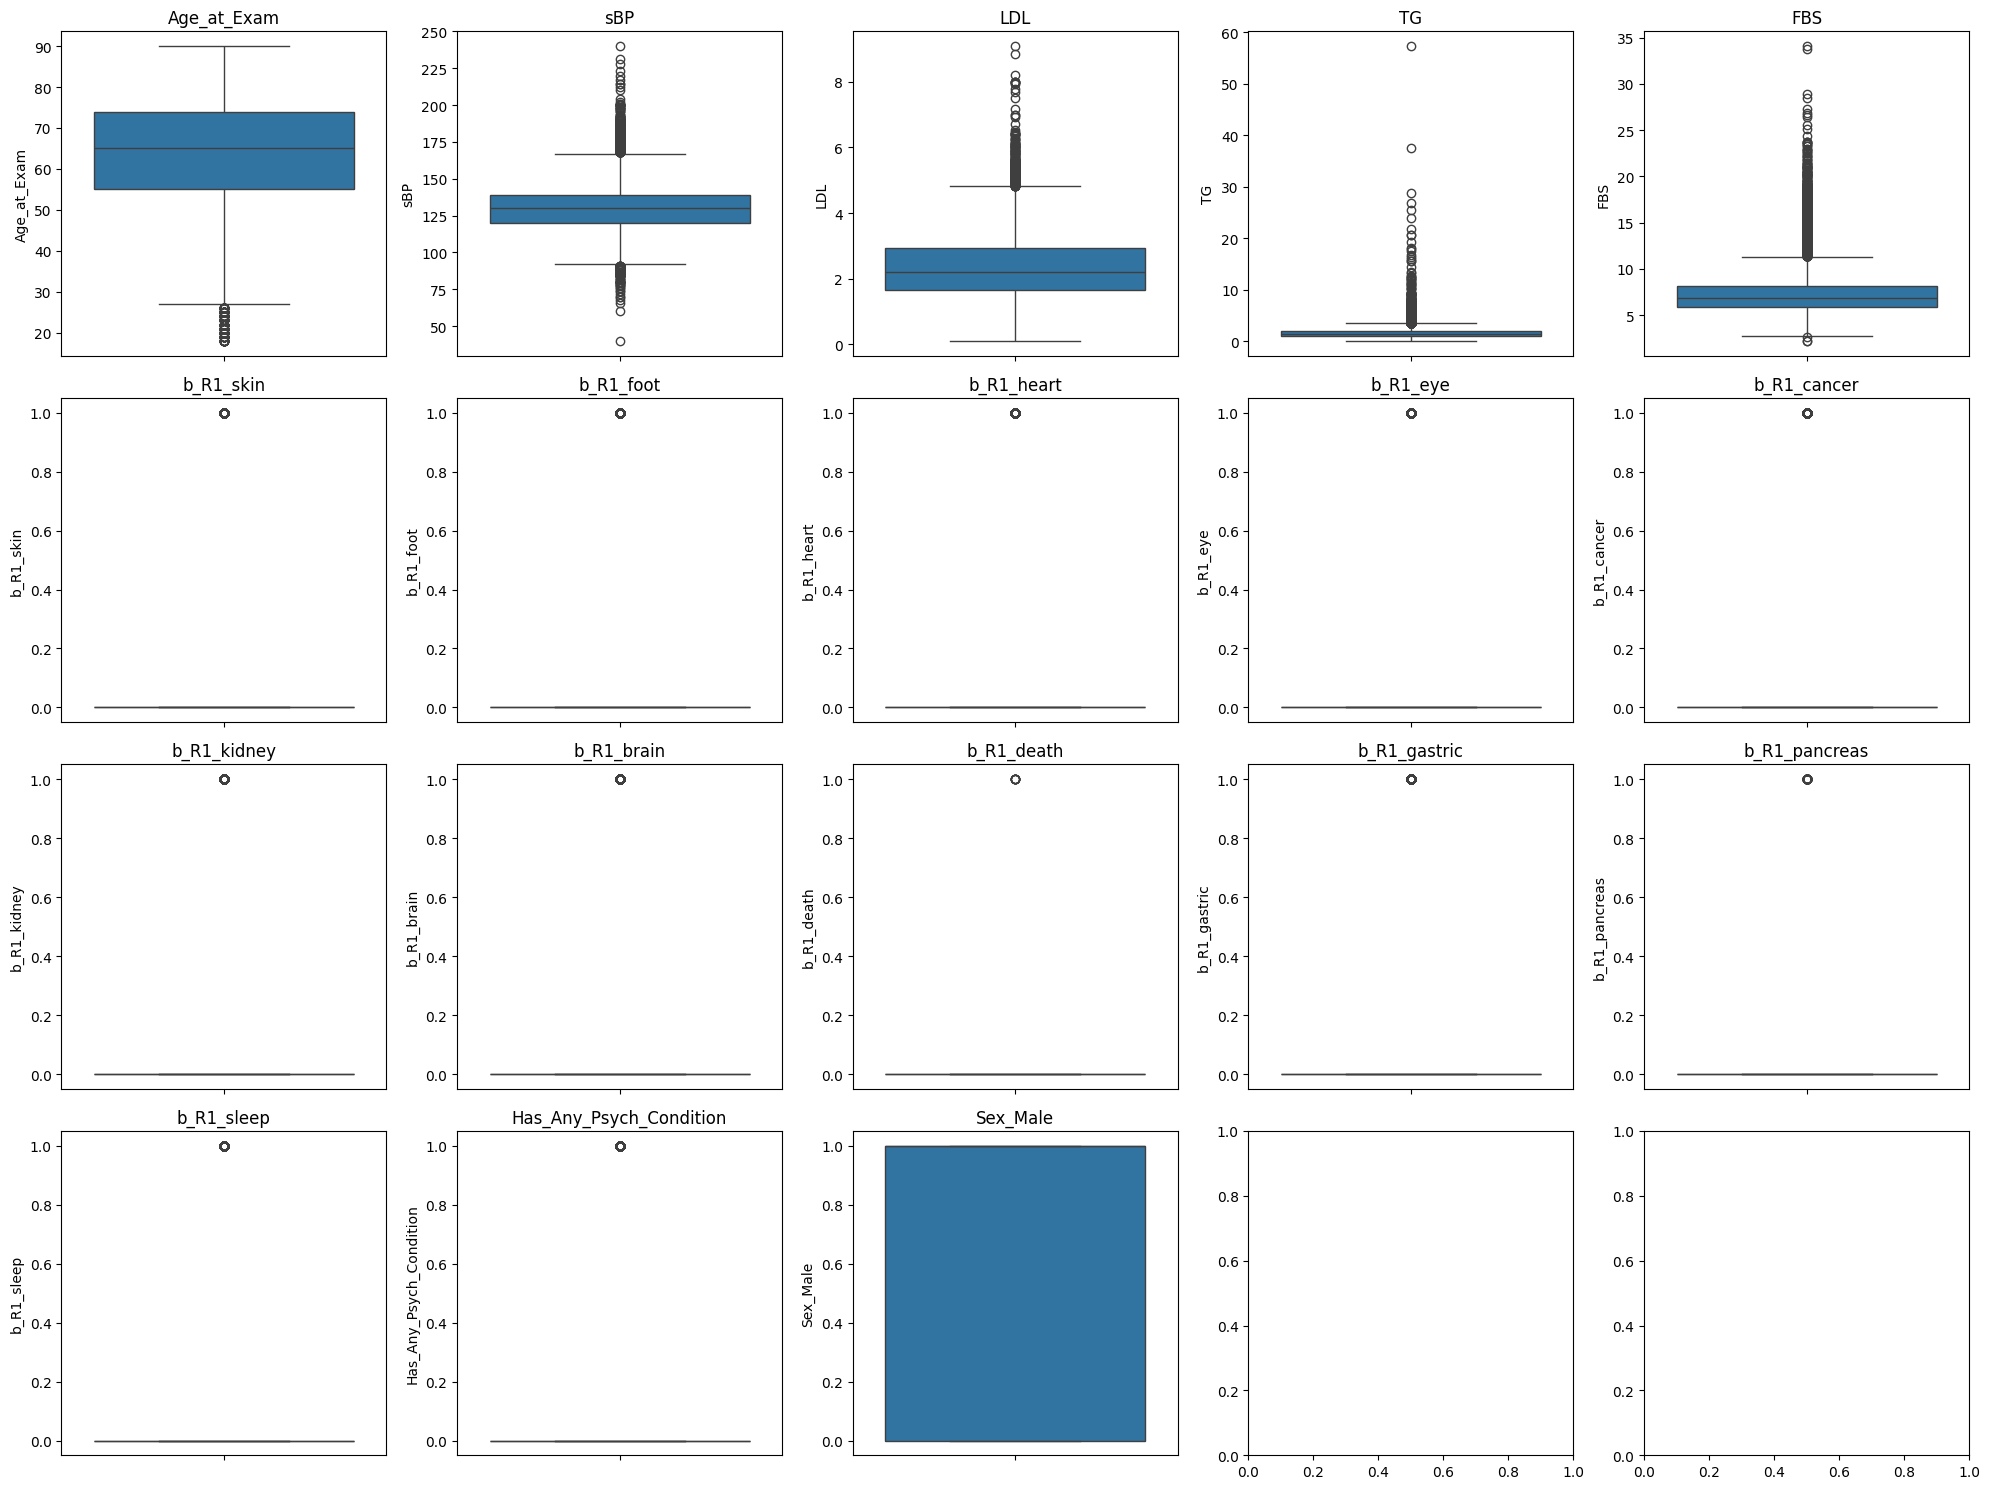

In [ ]:
# Set figure size
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 15))  # Adjust grid size based on number of columns
axes = axes.flatten()

# Plot each column separately
for i, col in enumerate(selectedD.columns):
    sns.boxplot(y=selectedD[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

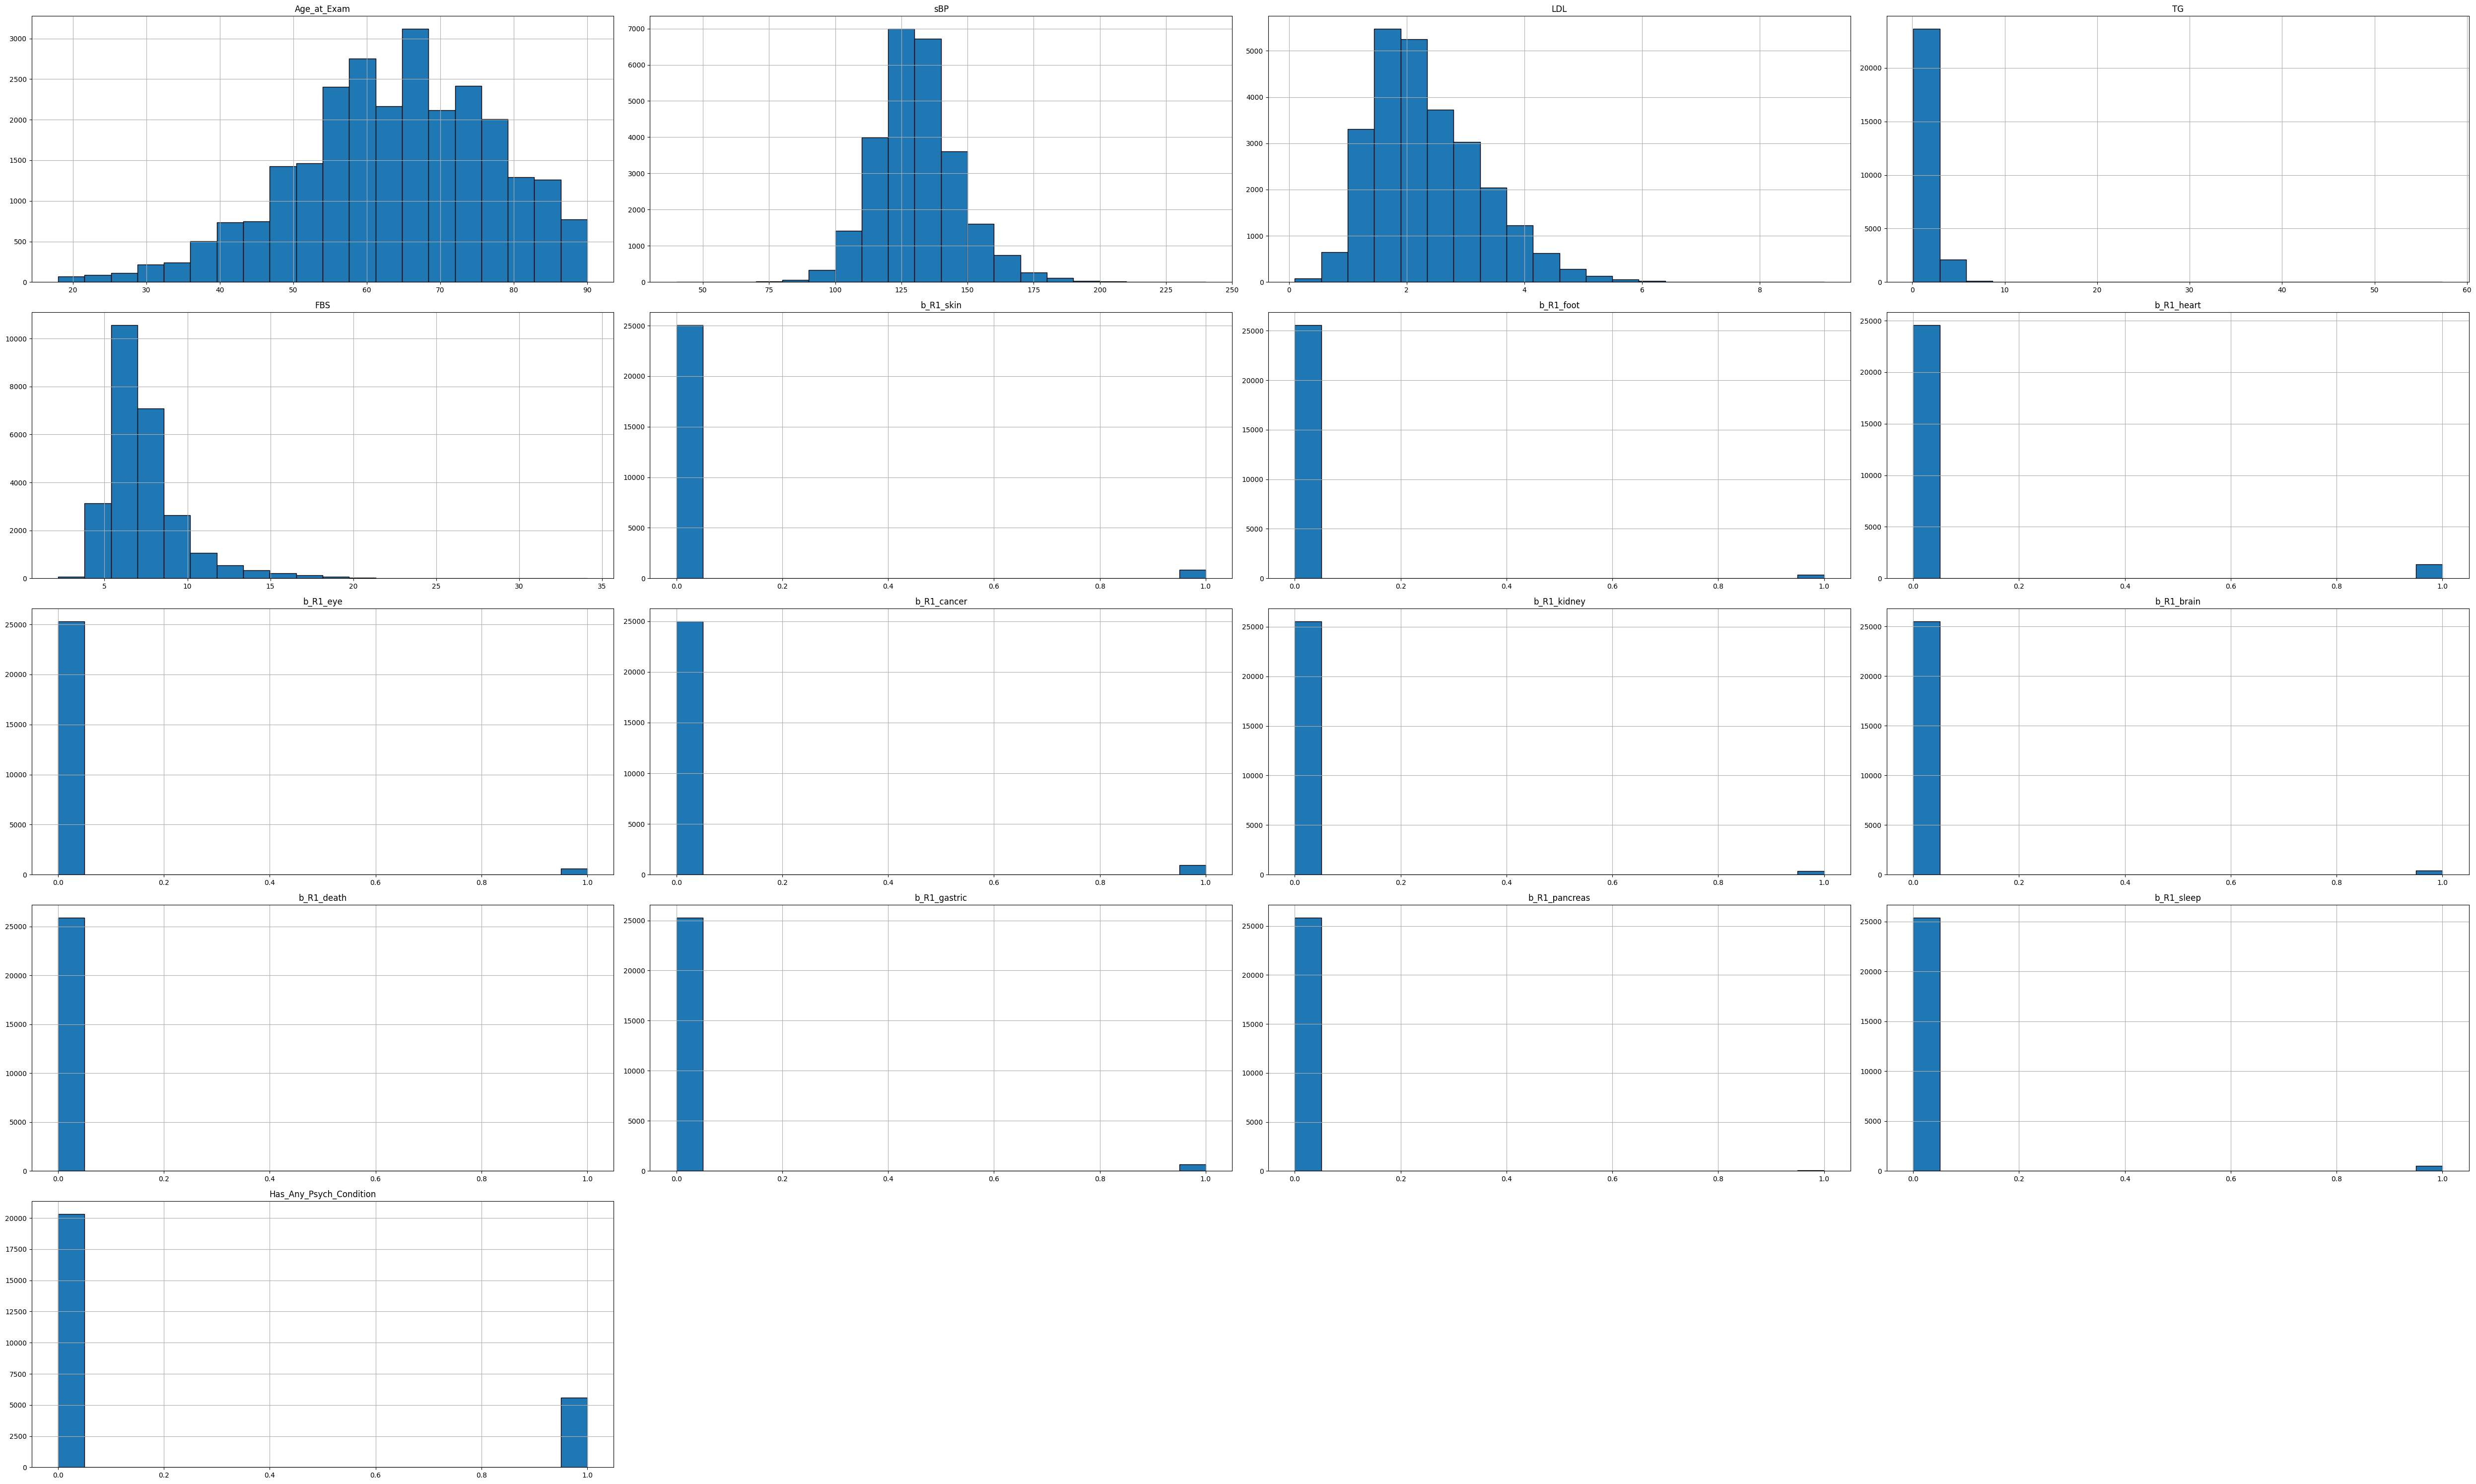

In [ ]:
# Set the number of bins for histograms
bins = 20

# Plot histograms for all numeric columns
selectedD.hist(figsize=(50, 30), bins=bins, edgecolor="black")

# Show the plots
plt.tight_layout()
plt.show()

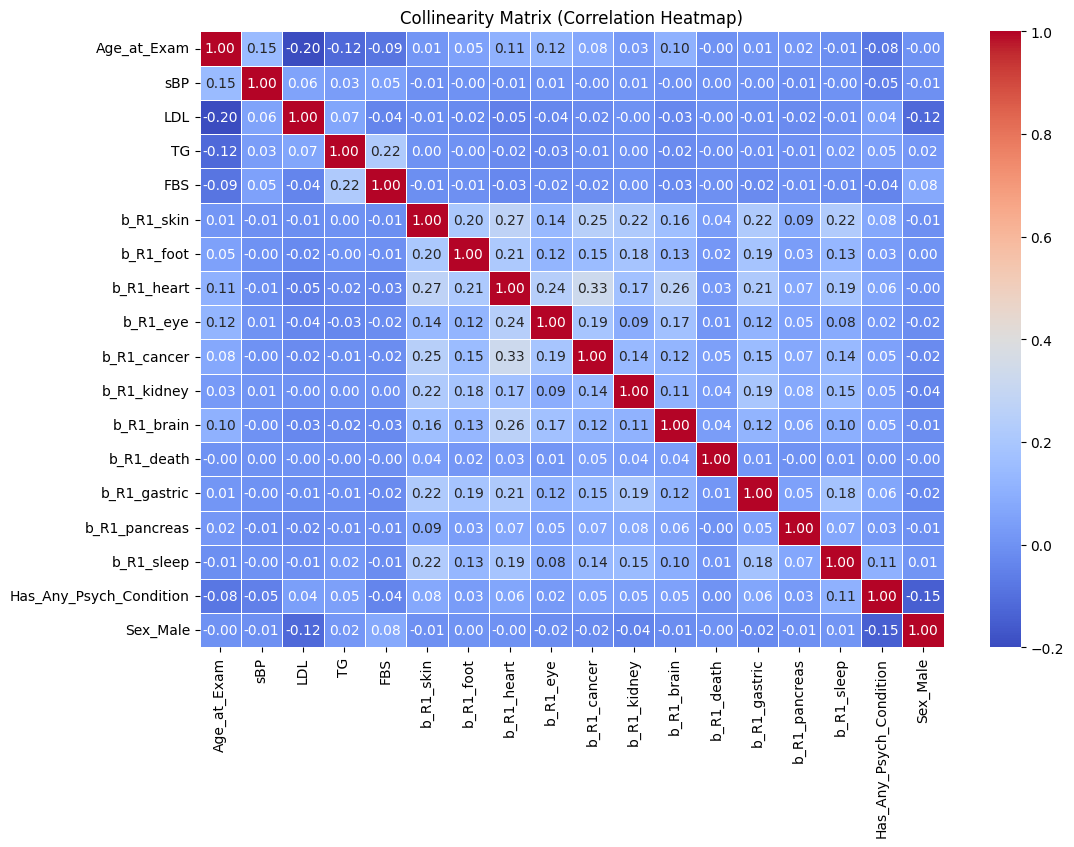

In [ ]:
# Compute the correlation matrix
corr_matrix = selectedD.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Title
plt.title("Collinearity Matrix (Correlation Heatmap)")

# Show the plot
plt.show()

Non-diabetics

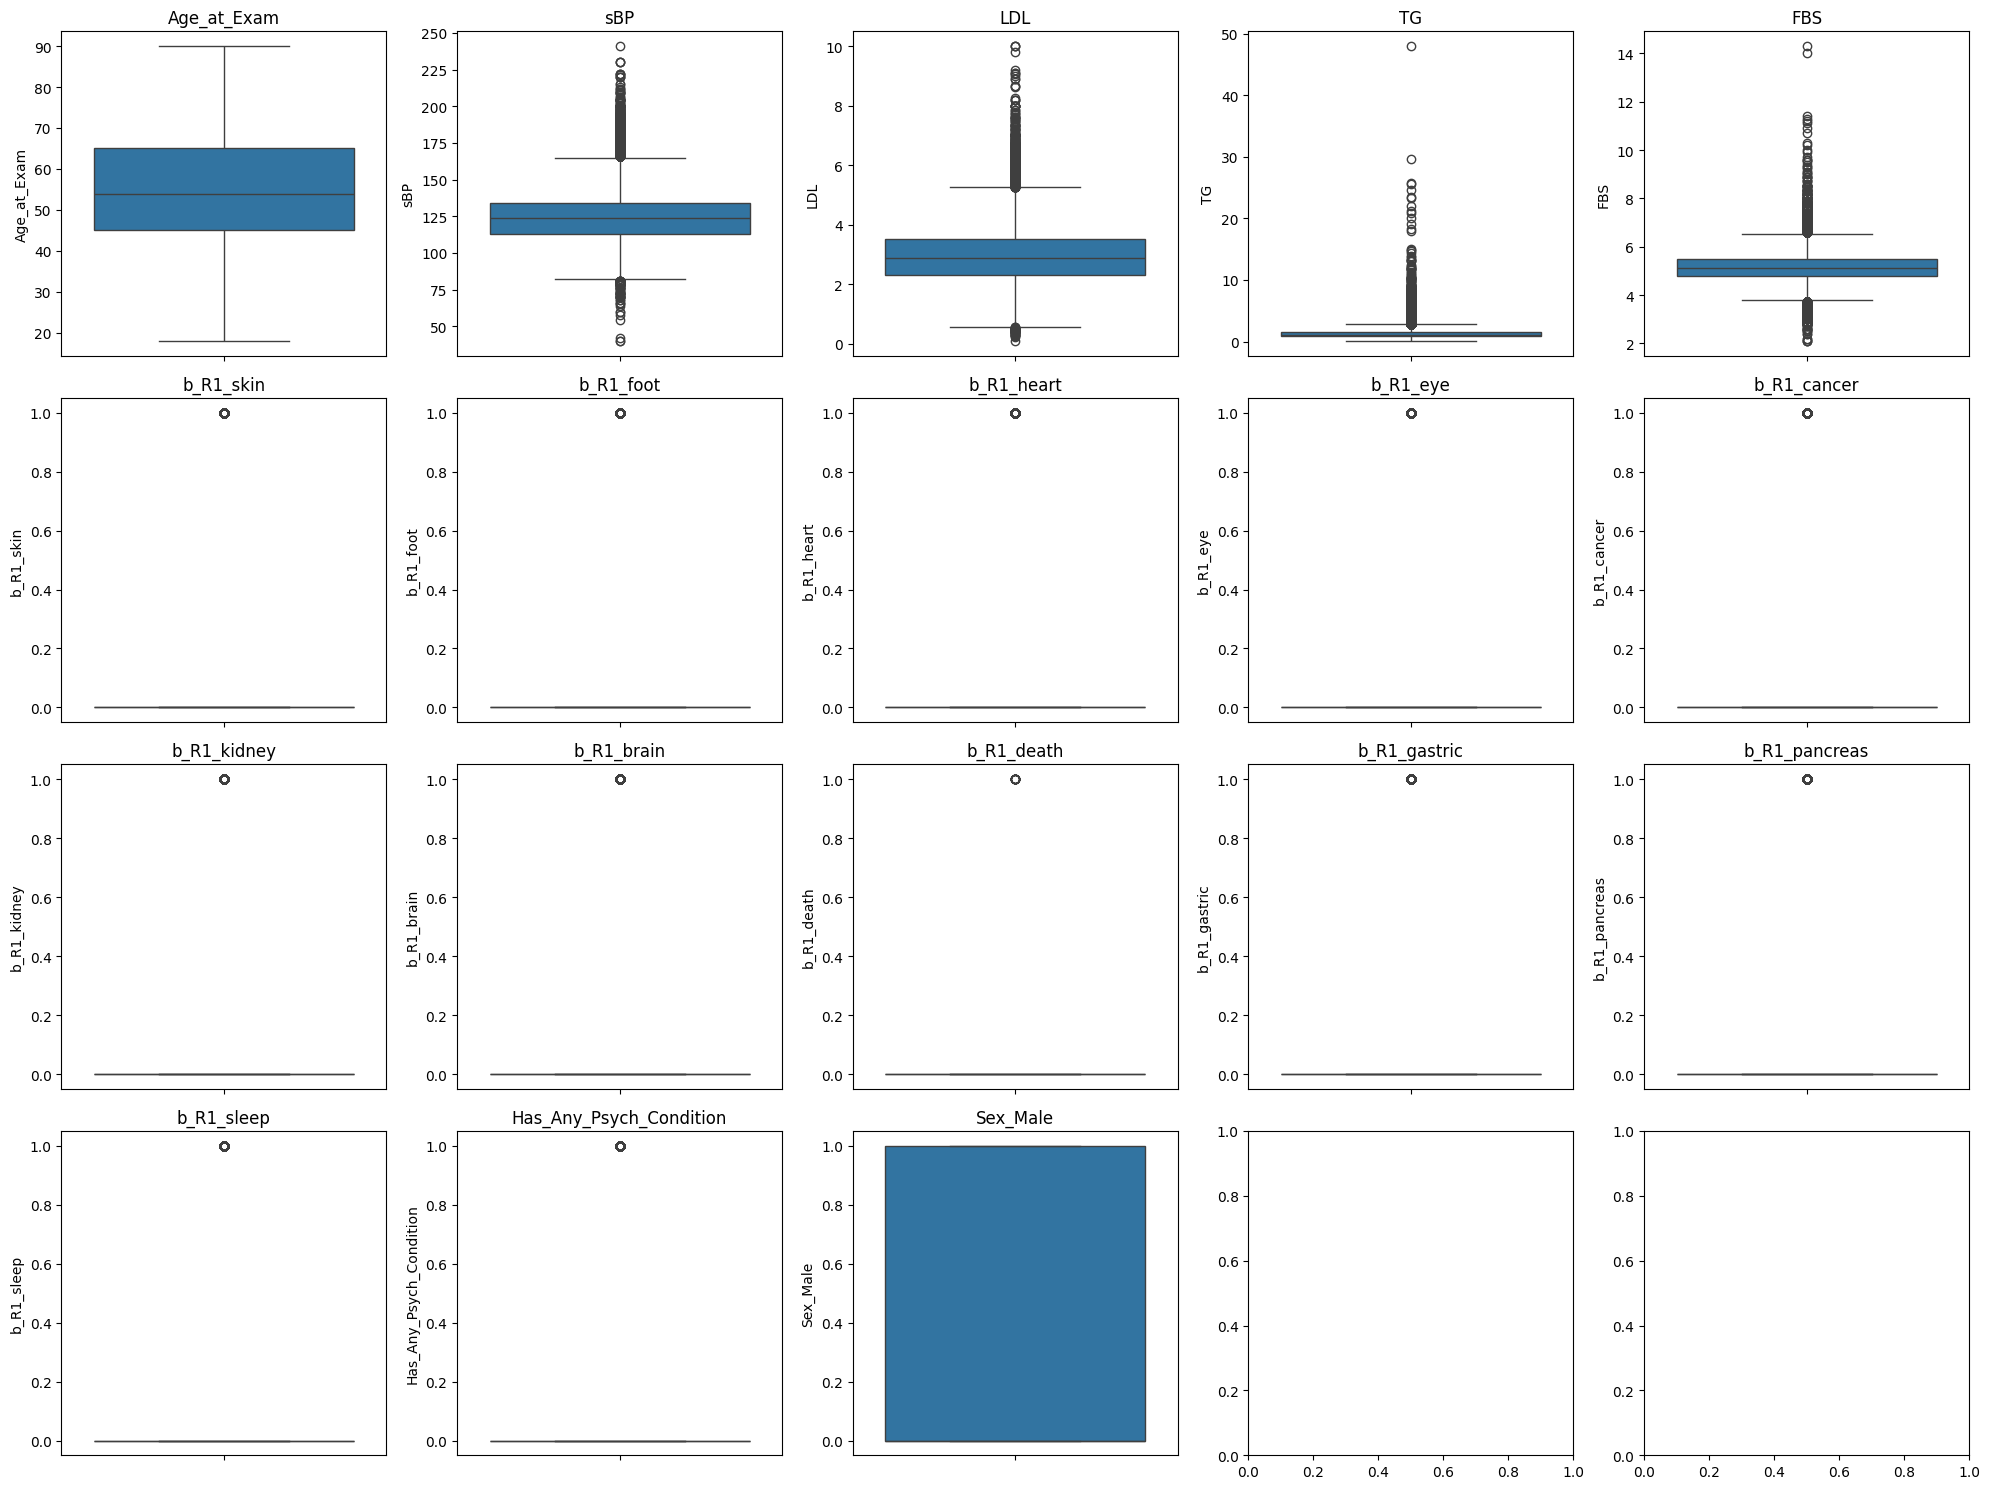

In [ ]:
# Set figure size
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 15))  # Adjust grid size based on number of columns
axes = axes.flatten()

# Plot each column separately
for i, col in enumerate(selectedND.columns):
    sns.boxplot(y=selectedND[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

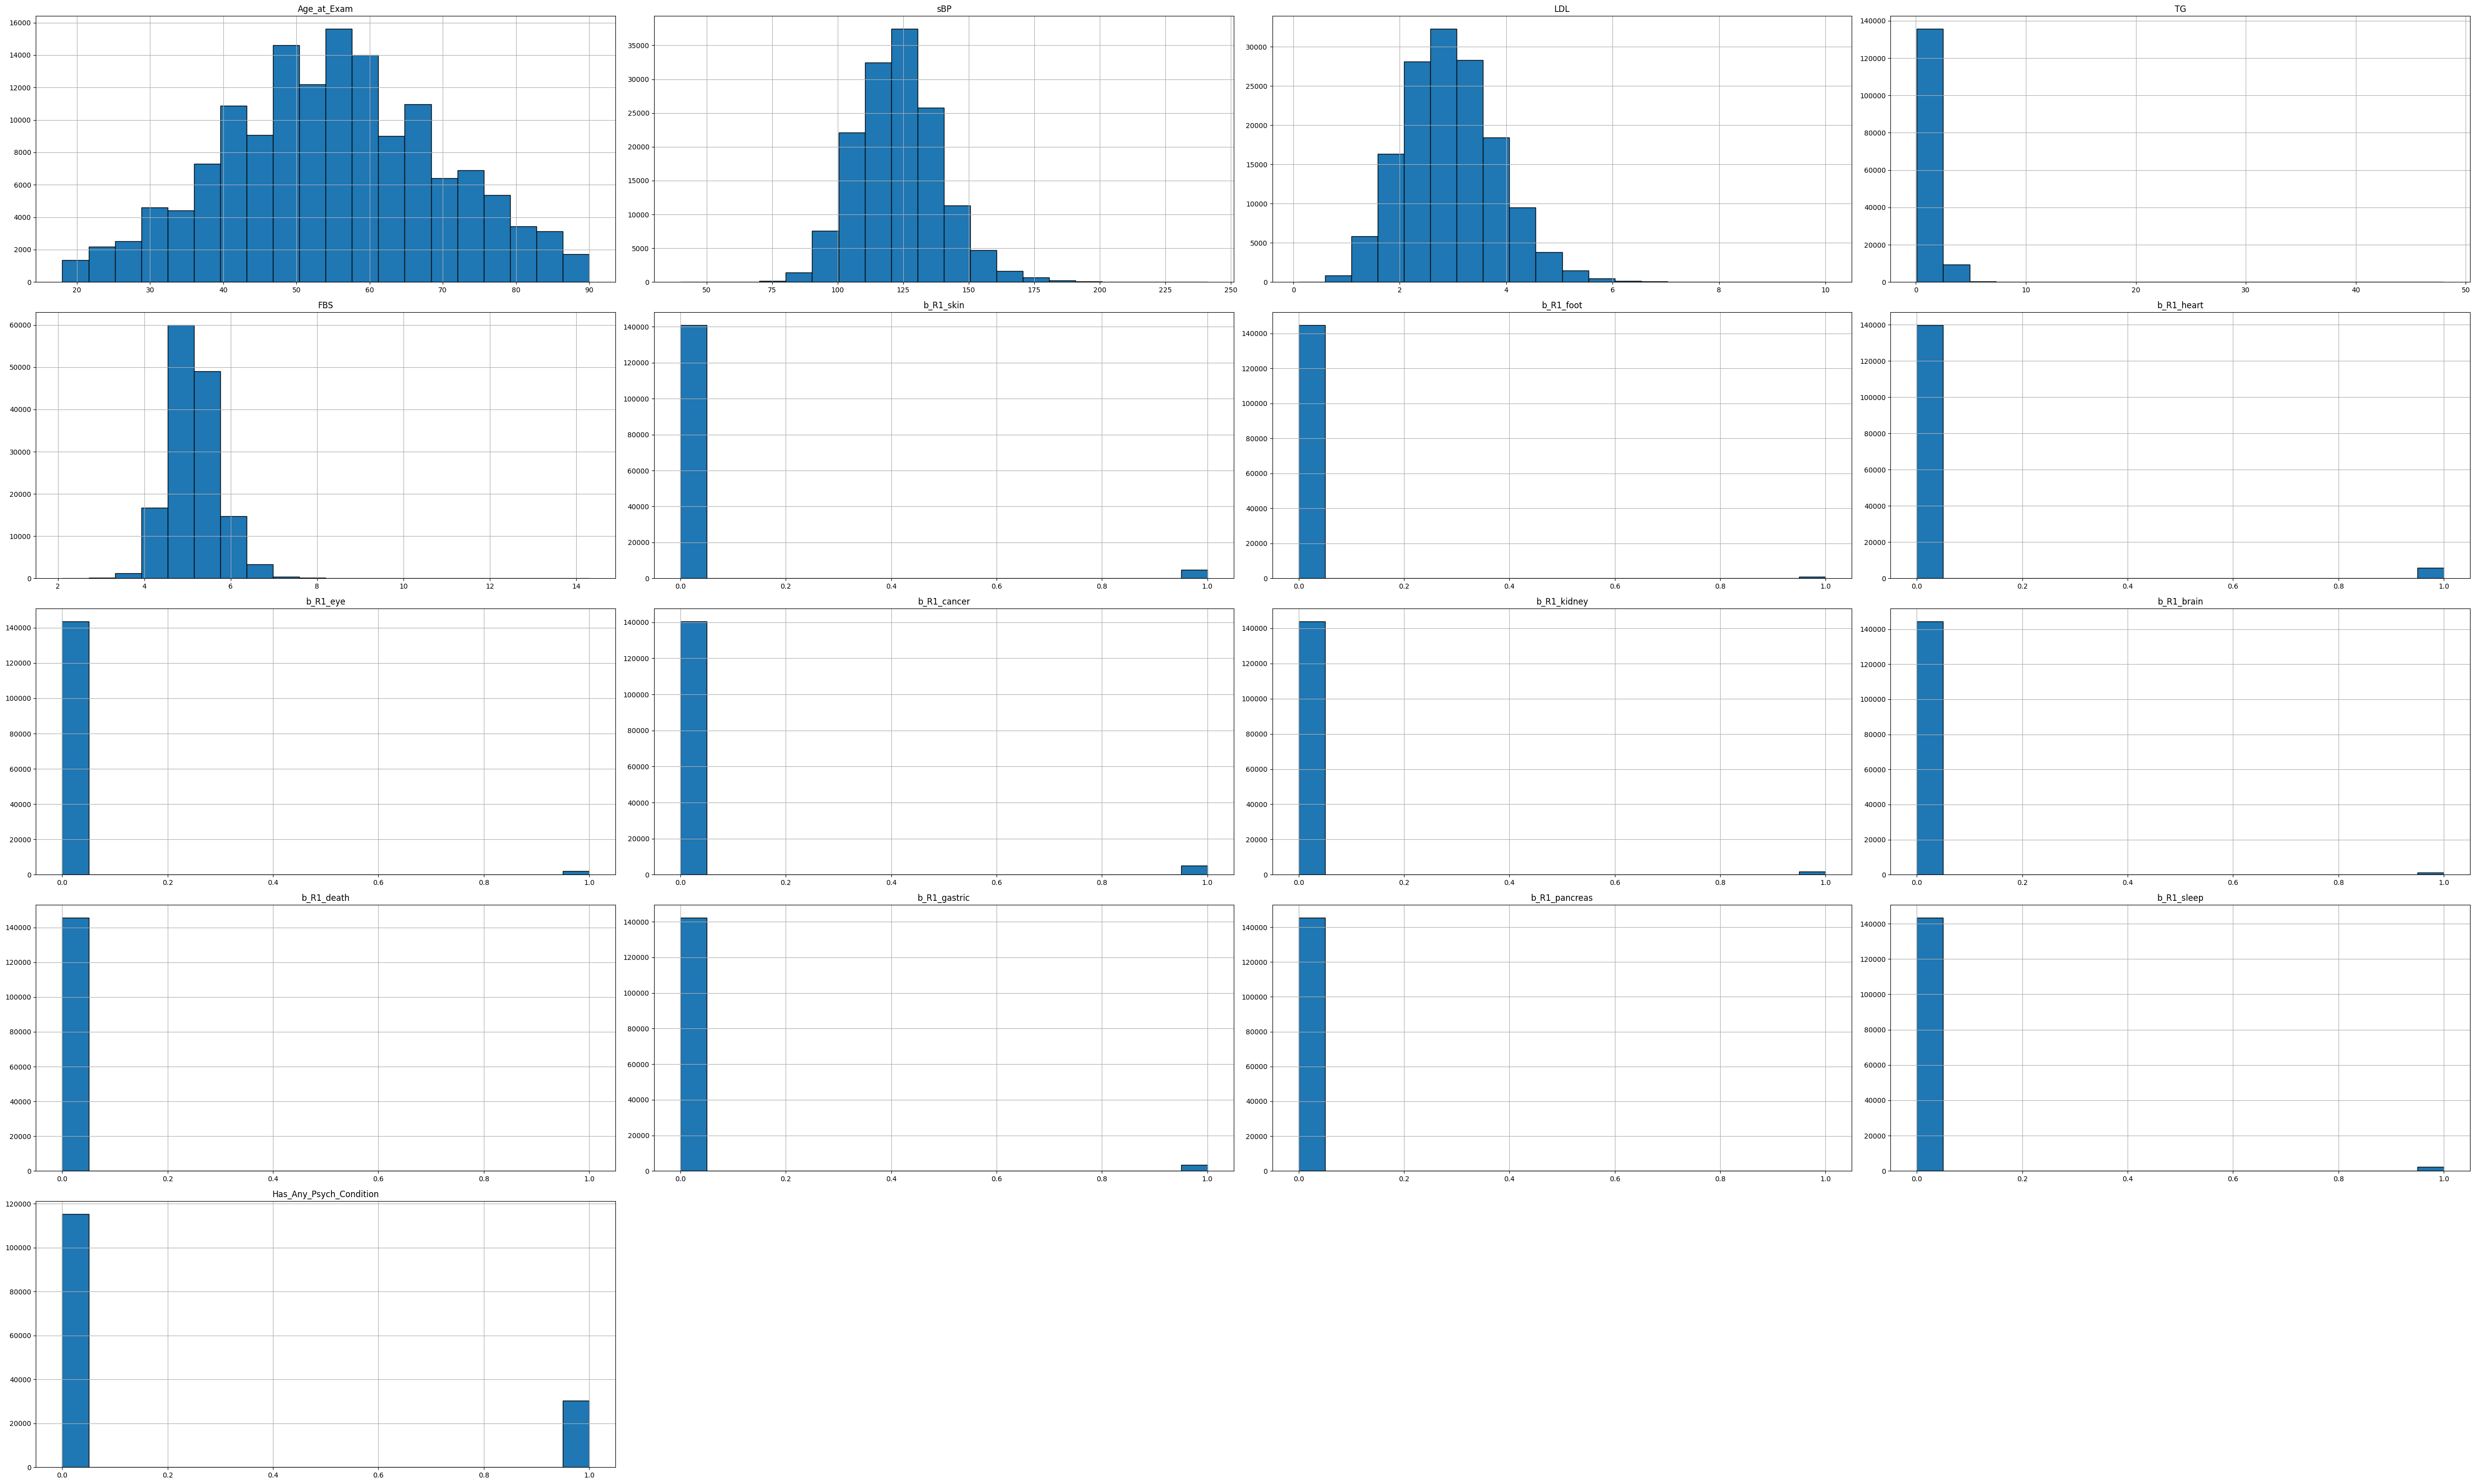

In [ ]:
# Set the number of bins for histograms
bins = 20

# Plot histograms for all numeric columns
selectedND.hist(figsize=(50, 30), bins=bins, edgecolor="black")

# Show the plots
plt.tight_layout()
plt.show()

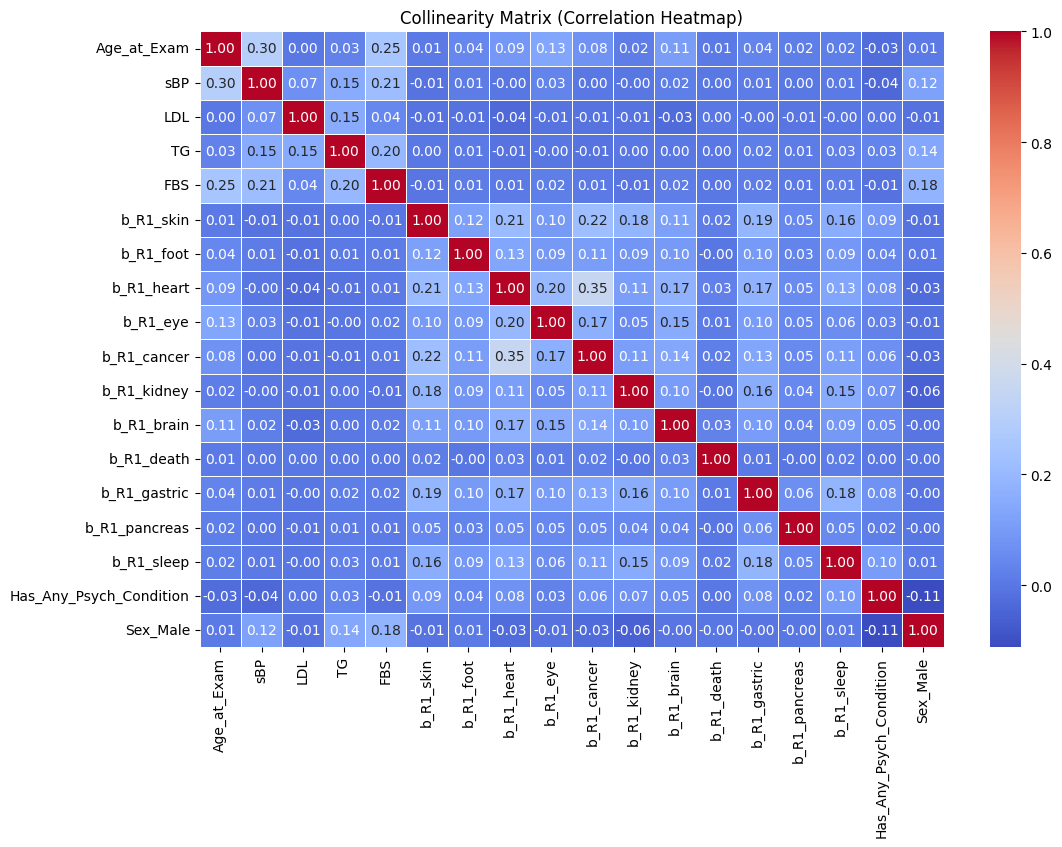

In [ ]:
# Compute the correlation matrix
corr_matrix = selectedND.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Title
plt.title("Collinearity Matrix (Correlation Heatmap)")

# Show the plot
plt.show()

# LOGISTIC REGRESSION

DIABETES

In [ ]:
# Split the data into features and target variable
X = selectedD.drop('Has_Any_Psych_Condition', axis=1)
y = selectedD['Has_Any_Psych_Condition']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on the training set
X_test = scaler.transform(X_test)        # transform the test set

# Apply undersampling to the training data
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Normalizing data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)  # Fit and transform on the resampled training set
X_test = scaler.transform(X_test)  # transform the test set

# Training logistic regression model
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)

# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[3612 2508]
 [ 658  998]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.59      0.70      6120
           1       0.28      0.60      0.39      1656

    accuracy                           0.59      7776
   macro avg       0.57      0.60      0.54      7776
weighted avg       0.73      0.59      0.63      7776



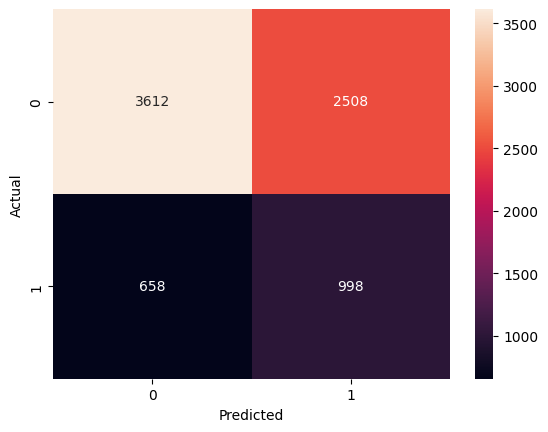

In [ ]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

No diabetes

In [ ]:
# Split the data into features and target variable
X = selectedND.drop('Has_Any_Psych_Condition', axis=1)
y = selectedND['Has_Any_Psych_Condition']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on the training set
X_test = scaler.transform(X_test)        # transform the test set

# Apply undersampling to the training data
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Normalizing data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)  # Fit and transform on the resampled training set
X_test = scaler.transform(X_test)  # transform the test set

# Training logistic regression model
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)

# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[19237 15394]
 [ 3591  5488]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.56      0.67     34631
           1       0.26      0.60      0.37      9079

    accuracy                           0.57     43710
   macro avg       0.55      0.58      0.52     43710
weighted avg       0.72      0.57      0.61     43710



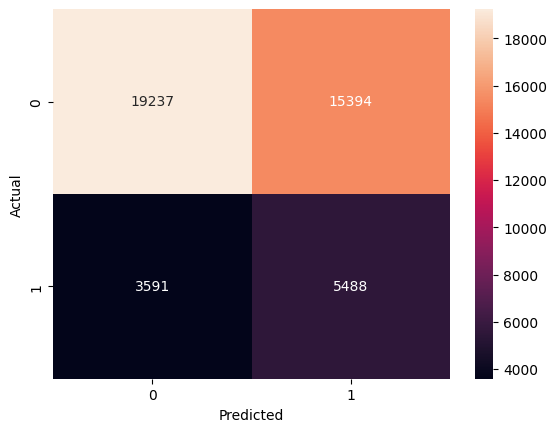

In [ ]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Define models with different regularization and hyperparameters
models = {
    'Baseline': LogisticRegression(),
    'L1': LogisticRegression(penalty='l1', solver='liblinear'),
    'L2': LogisticRegression(penalty='l2', solver='liblinear'),
    'ElasticNet': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5),
    'Tuned': GridSearchCV(
        LogisticRegression(),
        param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga']},
        cv=5,
        scoring='f1'  # Choose an appropriate scoring metric
    )
}

# Evaluate each model
results = []
for name, model in models.items():
    # Fit the model
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Store results
    results.append([name, accuracy, precision, recall, f1, roc_auc])

# Create a DataFrame for results
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'])

# Print the results
print(results_df)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

        Model  Accuracy  Precision    Recall  F1-Score   ROC AUC
0    Baseline  0.565660   0.262810  0.604472  0.366343  0.579978
1          L1  0.565660   0.262787  0.604362  0.366301  0.579938
2          L2  0.565637   0.262797  0.604472  0.366331  0.579964
3  ElasticNet  0.565683   0.262868  0.604692  0.366440  0.580074
4       Tuned  0.557035   0.261471  0.620773  0.367957  0.580549


All

In [ ]:
# Split the data into features and target variable
X = selectedALL.drop('Has_Any_Psych_Condition', axis=1)
y = selectedALL['Has_Any_Psych_Condition']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on the training set
X_test = scaler.transform(X_test)        # transform the test set

# Apply undersampling to the training data
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Normalizing data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)  # Fit and transform on the resampled training set
X_test = scaler.transform(X_test)  # transform the test set

# Training logistic regression model
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)

# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[21979 18635]
 [ 4055  6817]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.54      0.66     40614
           1       0.27      0.63      0.38     10872

    accuracy                           0.56     51486
   macro avg       0.56      0.58      0.52     51486
weighted avg       0.72      0.56      0.60     51486



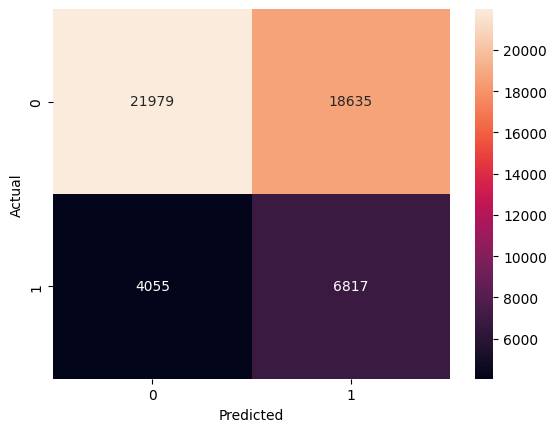

In [ ]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Define models with different regularization and hyperparameters
models = {
    'Baseline': LogisticRegression(),
    'L1': LogisticRegression(penalty='l1', solver='liblinear'),
    'L2': LogisticRegression(penalty='l2', solver='liblinear'),
    'ElasticNet': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5),
    'Tuned': GridSearchCV(
        LogisticRegression(),
        param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga']},
        cv=5,
        scoring='f1'  # Choose an appropriate scoring metric
    )
}

# Evaluate each model
results = []
for name, model in models.items():
    # Fit the model
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Store results
    results.append([name, accuracy, precision, recall, f1, roc_auc])

# Create a DataFrame for results
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'])

# Print the results
print(results_df)

        Model  Accuracy  Precision    Recall  F1-Score   ROC AUC
0    Baseline  0.559298   0.267837  0.627024  0.375344  0.584096
1          L1  0.559103   0.267915  0.627943  0.375585  0.584309
2          L2  0.559103   0.267915  0.627943  0.375585  0.584309
3  ElasticNet  0.559084   0.267922  0.628035  0.375609  0.584331
4       Tuned  0.554112   0.267462  0.639257  0.377133  0.585288


# RANDOM FOREST

ALL

In [ ]:
# Split the data into features and target variable
X = selectedALL.drop('Has_Any_Psych_Condition', axis=1)
y = selectedALL['Has_Any_Psych_Condition']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizing data (Not always necessary for Random Forest, but keeping for consistency)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on the training set
X_test = scaler.transform(X_test)        # Transform the test set

# Define hyperparameter grid for Randomized Search
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Randomized Search
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Updating the model's hyperparameters with the best parameters identified from Randomized Search
rf_model = random_search.best_estimator_

# Training Random Forest model
#rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Model evaluation
y_pred = rf_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Confusion Matrix:
[[39439  1175]
 [10031   841]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88     40614
           1       0.42      0.08      0.13     10872

    accuracy                           0.78     51486
   macro avg       0.61      0.52      0.50     51486
weighted avg       0.72      0.78      0.72     51486



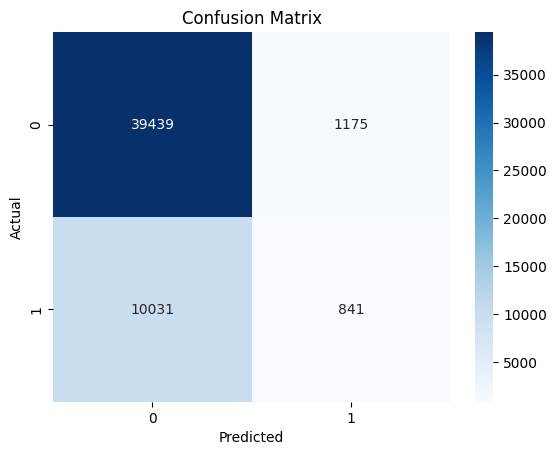

In [ ]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Diabetics

In [ ]:
# Split the data into features and target variable
X = selectedD.drop('Has_Any_Psych_Condition', axis=1)
y = selectedD['Has_Any_Psych_Condition']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizing data (Not always necessary for Random Forest, but keeping for consistency)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on the training set
X_test = scaler.transform(X_test)        # Transform the test set

# Define hyperparameter grid for Randomized Search
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Randomized Search
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Updating the model's hyperparameters with the best parameters identified from Randomized Search
rf_model = random_search.best_estimator_

# Training Random Forest model
#rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Model evaluation
y_pred = rf_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[5981  139]
 [1554  102]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.98      0.88      6120
           1       0.42      0.06      0.11      1656

    accuracy                           0.78      7776
   macro avg       0.61      0.52      0.49      7776
weighted avg       0.71      0.78      0.71      7776



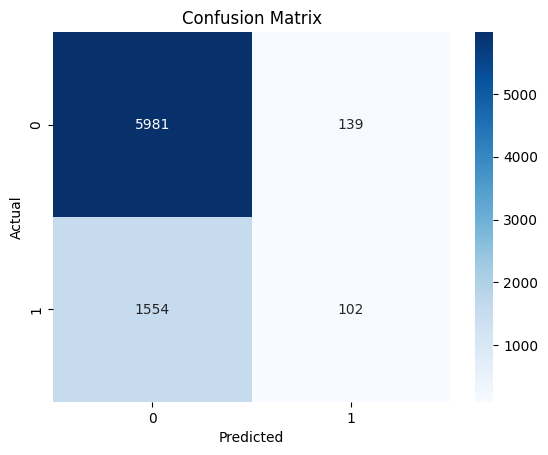

In [ ]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Non-diabetics

In [ ]:
# Split the data into features and target variable
X = selectedND.drop('Has_Any_Psych_Condition', axis=1)
y = selectedND['Has_Any_Psych_Condition']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalizing data (Not always necessary for Random Forest, but keeping for consistency)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on the training set
X_test = scaler.transform(X_test)        # Transform the test set

# Define hyperparameter grid for Randomized Search
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Randomized Search
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Updating the model's hyperparameters with the best parameters identified from Randomized Search
rf_model = random_search.best_estimator_

# Training Random Forest model
#rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Model evaluation
y_pred = rf_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[33782   849]
 [ 8532   547]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88     34631
           1       0.39      0.06      0.10      9079

    accuracy                           0.79     43710
   macro avg       0.60      0.52      0.49     43710
weighted avg       0.71      0.79      0.72     43710



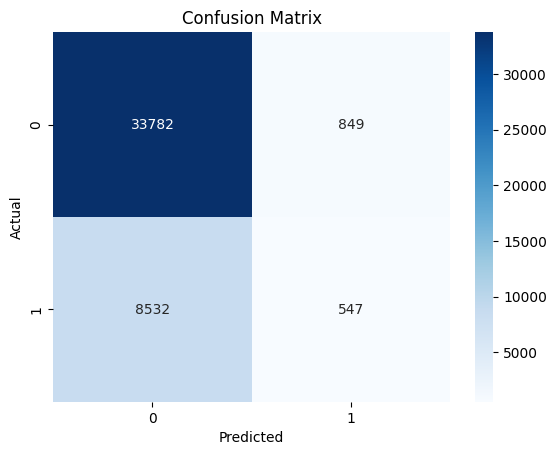

In [ ]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# XGBoost

ALL

In [ ]:
# Split the data into features (X) and target variable (y)
X = selectedALL.drop('Has_Any_Psych_Condition', axis=1)
y = selectedALL['Has_Any_Psych_Condition']

# Splitting the data into 70% training and 30% testing, ensuring class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)

# Calculating class prevalence in training and test sets
train_prevalence = y_train.value_counts(normalize=True)
test_prevalence = y_test.value_counts(normalize=True)

print("\nClass Prevalence in Training Set:")
print(train_prevalence)

print("\nClass Prevalence in Test Set:")
print(test_prevalence)

# Undersampling the majority class
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Initializing the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=10, use_label_encoder=False, eval_metric="logloss")

# Training the model on the resampled training dataset
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predicting on the training and test dataset
train_preds = xgb_model.predict(X_train_resampled)
test_preds = xgb_model.predict(X_test)

# Displaying accuracy scores
print(f"Training Accuracy: {accuracy_score(y_train_resampled, train_preds):.4f}")
print(f"Testing Accuracy: {accuracy_score(y_test, test_preds):.4f}")

# Defining hyperparameters for GridSearchCV
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [1, 5],
    "learning_rate": [0.1, 0.2],
    "min_child_weight": [25]  # Corrected hyperparameter name
}

# Using StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Setting up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=skf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fitting GridSearchCV on the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Displaying the best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Training the final model with the best parameters
best_xgb_model = xgb.XGBClassifier(**grid_search.best_params_, random_state=10, use_label_encoder=False, eval_metric="logloss")
best_xgb_model.fit(X_train_resampled, y_train_resampled)

# Predicting on the test dataset
final_preds = best_xgb_model.predict(X_test)

# Model evaluation
conf_matrix = confusion_matrix(y_test, final_preds)
class_report = classification_report(y_test, final_preds)

print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Class Prevalence in Training Set:
Has_Any_Psych_Condition
0    0.790782
1    0.209218
Name: proportion, dtype: float64

Class Prevalence in Test Set:
Has_Any_Psych_Condition
0    0.790778
1    0.209222
Name: proportion, dtype: float64


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:20:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 0.6734
Testing Accuracy: 0.5906
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:21:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 25, 'n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:21:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Confusion Matrix:
[[20738 19976]
 [ 3626  7146]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.51      0.64     40714
           1       0.26      0.66      0.38     10772

    accuracy                           0.54     51486
   macro avg       0.56      0.59      0.51     51486
weighted avg       0.73      0.54      0.58     51486



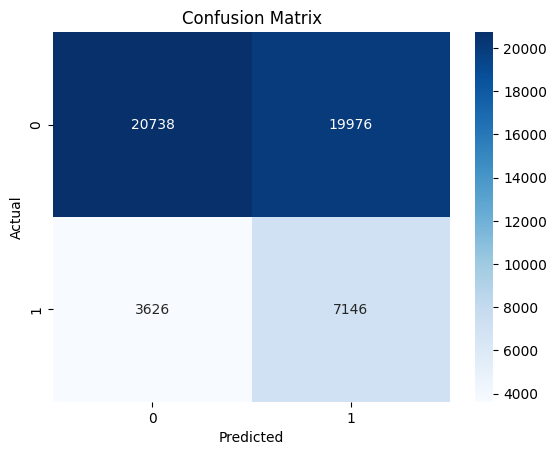

In [ ]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Diabetics

In [ ]:
# Split the data into features (X) and target variable (y)
X = selectedD.drop('Has_Any_Psych_Condition', axis=1)
y = selectedD['Has_Any_Psych_Condition']

# Splitting the data into 70% training and 30% testing, ensuring class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)

# Calculating class prevalence in training and test sets
train_prevalence = y_train.value_counts(normalize=True)
test_prevalence = y_test.value_counts(normalize=True)

print("\nClass Prevalence in Training Set:")
print(train_prevalence)

print("\nClass Prevalence in Test Set:")
print(test_prevalence)

# Undersampling the majority class
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Initializing the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=10, use_label_encoder=False, eval_metric="logloss")

# Training the model on the resampled training dataset
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predicting on the training and test dataset
train_preds = xgb_model.predict(X_train_resampled)
test_preds = xgb_model.predict(X_test)

# Displaying accuracy scores
print(f"Training Accuracy: {accuracy_score(y_train_resampled, train_preds):.4f}")
print(f"Testing Accuracy: {accuracy_score(y_test, test_preds):.4f}")

# Defining hyperparameters for GridSearchCV
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [1, 5],
    "learning_rate": [0.1, 0.2],
    "min_child_weight": [25]  # Corrected hyperparameter name
}

# Using StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Setting up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=skf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fitting GridSearchCV on the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Displaying the best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Training the final model with the best parameters
best_xgb_model = xgb.XGBClassifier(**grid_search.best_params_, random_state=10, use_label_encoder=False, eval_metric="logloss")
best_xgb_model.fit(X_train_resampled, y_train_resampled)

# Predicting on the test dataset
final_preds = best_xgb_model.predict(X_test)

# Model evaluation
conf_matrix = confusion_matrix(y_test, final_preds)
class_report = classification_report(y_test, final_preds)

print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Class Prevalence in Training Set:
Has_Any_Psych_Condition
0    0.784447
1    0.215553
Name: proportion, dtype: float64

Class Prevalence in Test Set:
Has_Any_Psych_Condition
0    0.784465
1    0.215535
Name: proportion, dtype: float64


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:21:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 0.8529
Testing Accuracy: 0.5797
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:21:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.2, 'max_depth': 1, 'min_child_weight': 25, 'n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:21:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Confusion Matrix:
[[3782 2318]
 [ 662 1014]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.62      0.72      6100
           1       0.30      0.61      0.40      1676

    accuracy                           0.62      7776
   macro avg       0.58      0.61      0.56      7776
weighted avg       0.73      0.62      0.65      7776



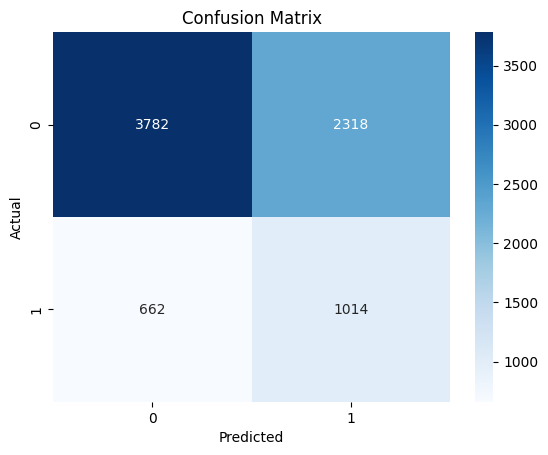

In [ ]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Non-diabetics

In [ ]:
# Split the data into features (X) and target variable (y)
X = selectedND.drop('Has_Any_Psych_Condition', axis=1)
y = selectedND['Has_Any_Psych_Condition']

# Splitting the data into 70% training and 30% testing, ensuring class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)

# Calculating class prevalence in training and test sets
train_prevalence = y_train.value_counts(normalize=True)
test_prevalence = y_test.value_counts(normalize=True)

print("\nClass Prevalence in Training Set:")
print(train_prevalence)

print("\nClass Prevalence in Test Set:")
print(test_prevalence)

# Undersampling the majority class
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Initializing the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=10, use_label_encoder=False, eval_metric="logloss")

# Training the model on the resampled training dataset
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predicting on the training and test dataset
train_preds = xgb_model.predict(X_train_resampled)
test_preds = xgb_model.predict(X_test)

# Displaying accuracy scores
print(f"Training Accuracy: {accuracy_score(y_train_resampled, train_preds):.4f}")
print(f"Testing Accuracy: {accuracy_score(y_test, test_preds):.4f}")

# Defining hyperparameters for GridSearchCV
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [1, 5],
    "learning_rate": [0.1, 0.2],
    "min_child_weight": [25]  # Corrected hyperparameter name
}

# Using StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Setting up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=skf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fitting GridSearchCV on the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Displaying the best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Training the final model with the best parameters
best_xgb_model = xgb.XGBClassifier(**grid_search.best_params_, random_state=10, use_label_encoder=False, eval_metric="logloss")
best_xgb_model.fit(X_train_resampled, y_train_resampled)

# Predicting on the test dataset
final_preds = best_xgb_model.predict(X_test)

# Model evaluation
conf_matrix = confusion_matrix(y_test, final_preds)
class_report = classification_report(y_test, final_preds)

print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Class Prevalence in Training Set:
Has_Any_Psych_Condition
0    0.791909
1    0.208091
Name: proportion, dtype: float64

Class Prevalence in Test Set:
Has_Any_Psych_Condition
0    0.791901
1    0.208099
Name: proportion, dtype: float64


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:21:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 0.6907
Testing Accuracy: 0.5893
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:21:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 25, 'n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:21:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Confusion Matrix:
[[17250 17364]
 [ 3067  6029]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.50      0.63     34614
           1       0.26      0.66      0.37      9096

    accuracy                           0.53     43710
   macro avg       0.55      0.58      0.50     43710
weighted avg       0.73      0.53      0.57     43710



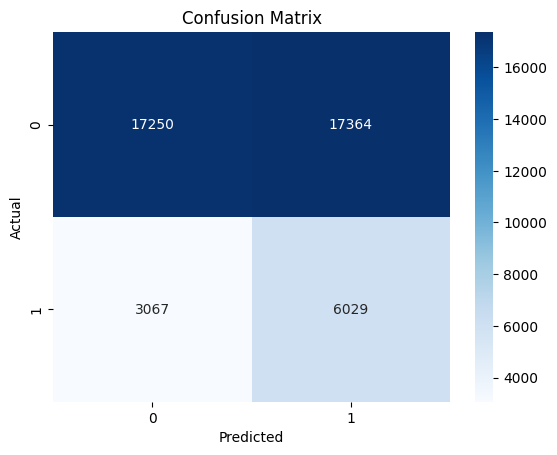

In [ ]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()